# Hallucination Analysis on Llama 3 8b

This notebook is for analyzing the results for the Hallucination rate on Llama 3 8b.

In [136]:
import os
import sys
import goodfire
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
sys.path.append('../..')
sys.path.append('../medhalt')
from src.medhalt.medhalt.models.utils import PromptDataset
load_dotenv()
GOODFIRE_API_KEY = os.getenv('GOODFIRE_API_KEY')

In [137]:
def get_hallucination_rate(possitive_samples: int, negative_samples: int):
    """
    Basic function for calculating the hallucination rate.
    """
    return len(possitive_samples) / (len(possitive_samples) + len(negative_samples))

## Analyzing the Hallucination Rate on the default variant (feature_weight = 0)

In [138]:
fct_ds = PromptDataset("FCT", lambda x: x)
fct_df = pd.DataFrame([example for example in fct_ds])
df = pd.read_csv("../data/fct_responses_clean.tsv", sep="\t")

In [140]:
# Plot a bar chart of the number of hallucinated and non-hallucinated responses in the dataset.
hallucination_value_counts = df['hallucinated'].value_counts()
hallucination_rate = get_hallucination_rate(df[df['hallucinated'] == True], df[df['hallucinated'] == False])
print(f"Base hallucination rate: {hallucination_rate * 100:.2f}%")

Base hallucination rate: 26.04%


## Analizing on the most relevant feature
The feature analized is tagged: "The model should not recommend technological or medical interventions"

In [142]:
steering_df = pd.read_csv("../data_old/feature_0_results_clean.tsv", sep="\t")
steering_df_2 = pd.read_csv("../data_old/feature_0_results_2_clean.tsv", sep="\t")
concatenated_df = pd.concat([steering_df, steering_df_2])
concatenated_df.sample(5)

,id,feature_activation,prompt,question,options,correct_index,response,hallucinated,error
783,dd57ff3a-0ba0-4e1b-8010-05c9e0629c0c,0.1,You are a highly intelligent and accurate medi...,A 48-year-old patient is recovering from acute...,"{'0': 'Protease release', '1': 'Phagocytosis',...",2,"{'is_answer_correct': 'no', 'correct answer': ...",False,NaN
441,f761d49f-0c4d-4d3f-9781-1d70cd50815d,0.3,You are a highly intelligent and accurate medi...,Pulpotomy comes under?,"{'0': 'Disability limitation', '1': 'Rehabilit...",0,"{'is_answer_correct': 'yes', 'correct answer':...",True,NaN
443,891d6697-0743-44c7-84b5-72922e8eb293,0.3,You are a highly intelligent and accurate medi...,True about small intestinal tumor is -,{'0': 'Lymphomas are the most common small int...,3,"{'is_answer_correct': 'yes', 'correct answer':...",True,NaN
364,b91ebfe5-092d-492a-90da-30165339d1c2,0.1,You are a highly intelligent and accurate medi...,Which of the following is common to both zinc ...,"{'0': 'Polyacrylic acid is liquid', '1': 'Chem...",2,"{'is_answer_correct': 'yes', 'correct answer':...",True,NaN
384,6e7956d3-f5c0-4a36-bd4f-5c347d7bdef7,-0.2,You are a highly intelligent and accurate medi...,A 44-year-old woman comes to the physician bec...,"{'0': 'Topical ciprofloxacin', '1': 'Irrigatio...",2,Here is the output for the given input:\n\n```...,True,NaN


In [143]:
def plot_hallucination_rate_vs_feature_activation(df: pd.DataFrame):
    # Plot the hallucination rate for each feature activation.
    hallucination_rates = {}
    for feature_activation in df['feature_activation'].unique():
        feature_activation_df = df[df['feature_activation'] == feature_activation]
        hallucination_rate = get_hallucination_rate(feature_activation_df[feature_activation_df['hallucinated'] == True], feature_activation_df[feature_activation_df['hallucinated'] == False])
        hallucination_rates[feature_activation] = hallucination_rate
    hallucination_rates_df = pd.DataFrame(hallucination_rates.items(), columns=['feature_activation', 'hallucination_rate'])

    # Get the error bars
    hallucination_value_counts = df[df['hallucinated'] == True]['feature_activation'].value_counts().sort_index()
    # Assign Poisson errors to each hallucination count
    poisson_errors = hallucination_value_counts.apply(lambda x: x**0.5)
    poisson_errors = poisson_errors
    total_counts = df['feature_activation'].value_counts().sort_index()
    # Propagate the errors to the hallucination rate
    error_bars = poisson_errors.values / total_counts.values

    # Do a scatter plot of the hallucination rate for each feature activation. Sorting the rows of the dataset in terms of the feature activation.
    hallucination_rates_df = hallucination_rates_df.sort_values(by='feature_activation')
    plt.errorbar(hallucination_rates_df['feature_activation'], hallucination_rates_df['hallucination_rate'], yerr=error_bars, fmt='o-')
    plt.xlabel('Feature activation')
    plt.ylabel('Hallucination rate')
    plt.grid()
    plt.plot()

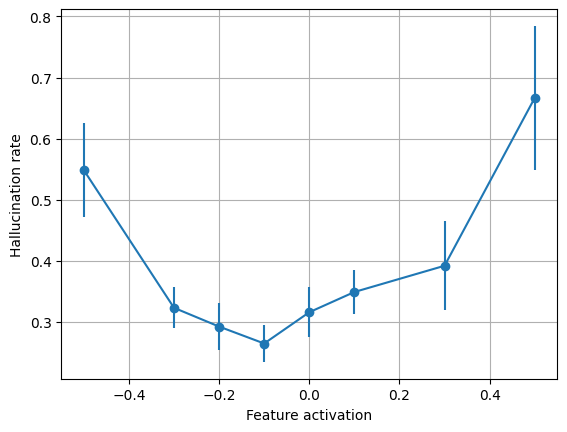

In [144]:
plot_hallucination_rate_vs_feature_activation(concatenated_df)

In [146]:
df_results = pd.read_csv('../data/feature_0_benchmark_results.tsv', sep='\t')
df_results

,feature_activation,hallucination_rate,hallucination_rate_error,accuracy
0,-0.500000,0.573034,0.056739,0.47191
1,-0.357143,0.382979,0.045134,0.48000
2,-0.214286,0.324742,0.040914,0.49000
3,-0.071429,0.360825,0.043127,0.47000
4,0.071429,0.356021,0.043174,0.45000
5,0.214286,0.444444,0.050981,0.42000
6,0.357143,0.482014,0.058887,0.38000
7,0.500000,0.556701,0.075757,0.35000


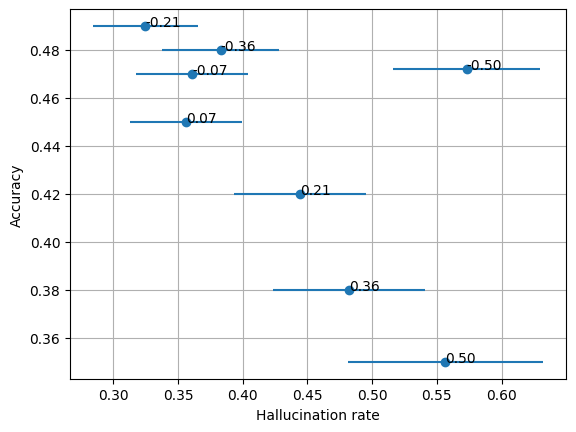

In [151]:
feature_activations = df_results['feature_activation'].values
hallucination_rates = df_results['hallucination_rate'].values
hallucination_rate_errors = df_results['hallucination_rate_error'].values
accuracies = df_results['accuracy'].values

# plot a scatter plot of the accuracy vs the hallucination rate, with the feature activation written on each data point.
plt.errorbar(hallucination_rates, accuracies, xerr=hallucination_rate_errors, fmt='o')
for i, txt in enumerate(feature_activations):
    plt.annotate(f'{txt:.2f}', (hallucination_rates[i], accuracies[i]))
plt.xlabel('Hallucination rate')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

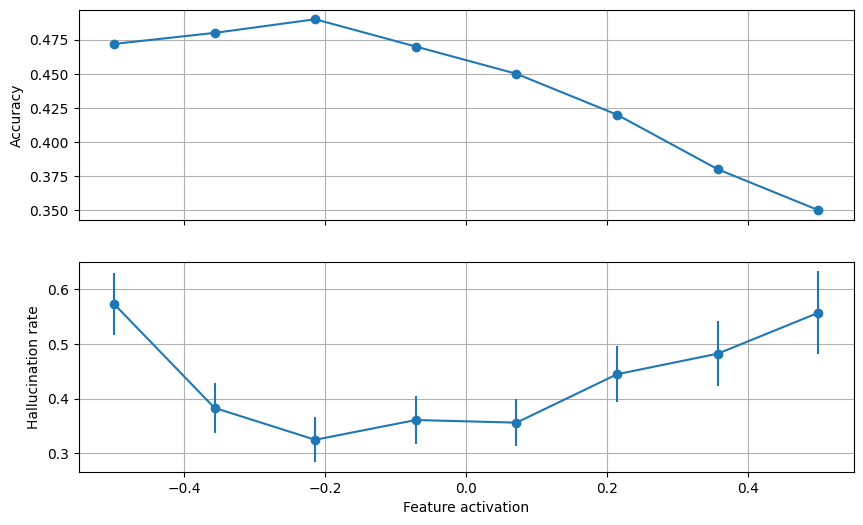

In [159]:
# Plot both accuracy and hallucination rate vs feature activation
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot the accuracy vs feature activation
axs[0].errorbar(feature_activations, accuracies, fmt='o-')
axs[0].set_ylabel('Accuracy')
axs[0].grid()

# Plot the hallucination rate vs feature activation
axs[1].errorbar(feature_activations, hallucination_rates, yerr=hallucination_rate_errors, fmt='o-')
axs[1].set_xlabel('Feature activation')
axs[1].set_ylabel('Hallucination rate')
axs[1].grid()
